In [1]:
from argparse import Namespace
import sys

sys.path.insert(0, '..')

from tqdm import tqdm
from PIL import Image
import numpy as np
import torch

from models.psp import pSp
from models.stylegan2.model import Generator
from utils.tensor2im import tensor2im
from transforms.sam_transforms import test_transform as tfm
from transforms.age_transforms import add_aging_channel

In [2]:
# # Create decoder to generate images from latents
# decoder = Generator(size=1024, style_dim=512, n_mlp=8)
# decoder.load_state_dict(torch.load('../pretrained_models/stylegan2-ffhq-config-f.pt')['g'])
# decoder = decoder.cuda()

# Create encoder-decoder to change age of image
ckpt_path = '../pretrained_models/sam_ffhq_aging.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')
opts = ckpt['opts']
opts = Namespace(**opts)
opts.checkpoint_path = ckpt_path
net = pSp(opts).eval().cuda()

Loading SAM from checkpoint: ../pretrained_models/sam_ffhq_aging.pt


In [3]:
from random import randint
import math


def get_rand_ages(
    min_age=18,
    max_age=85,
    num_ages=14
):
    all_ages = torch.arange(min_age, max_age + 1)
    age_chunks = torch.split(all_ages, math.ceil(len(all_ages)/num_ages))
    return torch.tensor([age_chunk[randint(0, len(age_chunk) - 1)] for age_chunk in age_chunks])

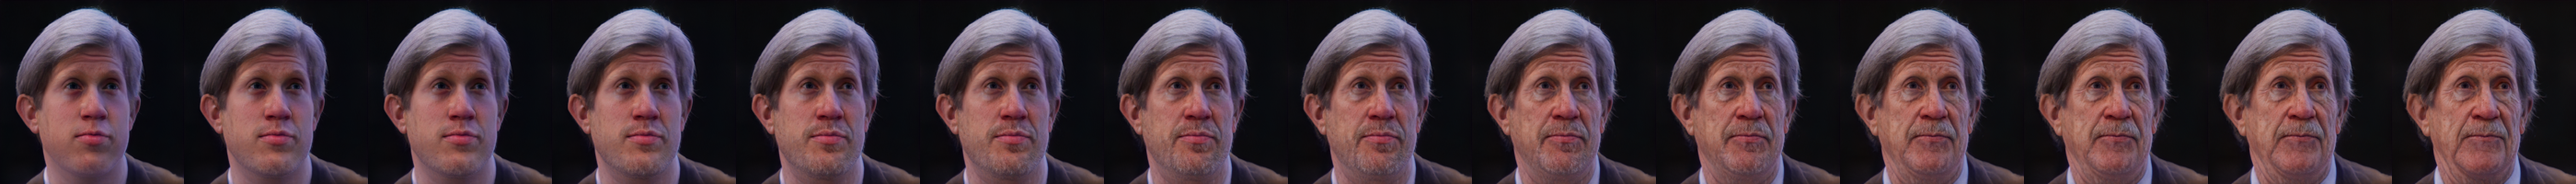

In [4]:
z = torch.randn(1, 1, 512).to('cuda')

with torch.no_grad():
    (img,), _ = net.decoder(z)

im = tensor2im(img)

input_age_batch = torch.stack([
    add_aging_channel(tfm(im), age)
    for age in get_rand_ages()
]).cuda()

with torch.no_grad():
    results = net(input_age_batch, randomize_noise=False, resize=False)
    
Image.fromarray(np.concatenate([
    tensor2im(result).resize((200, 200))
    for result in results
], axis=1))

In [5]:
from pathlib import Path


data_root = Path('../data/FRAN_dataset')


num_ages = 14
num_samples = 2500

for i in tqdm(range(num_samples)):
    z = torch.randn(1, 1, 512).to('cuda')

    with torch.no_grad():
        (img,), _ = net.decoder(z)

    im = tensor2im(img)

    ages = get_rand_ages(num_ages=num_ages)
    input_age_batch = torch.stack([
        add_aging_channel(tfm(im), age)
        for age in ages
    ]).cuda()

    with torch.no_grad():
        results = net(input_age_batch, randomize_noise=False, resize=False)

    for result, age in zip(results, ages):
        result_im = tensor2im(result)
        out_path = data_root / f'{i:04}/{i:04}_{age:02}.jpg'
        out_path.parent.mkdir(exist_ok=True, parents=True)
        result_im.save(out_path)

100%|██████████| 2500/2500 [48:12<00:00,  1.16s/it]


# Visualize

In [6]:
tensor2im(result[2])

RuntimeError: number of dims don't match in permute